In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"   # OpenMP 线程数
os.environ["MKL_NUM_THREADS"] = "4"   # MKL 线程数
os.environ["NUMEXPR_NUM_THREADS"] = "4"  # NumExpr 线程数
import mi
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
# spot = 150
data_name = 'mouse_old_sub'
sc_data = sc.read('../scripts/data/public_mouse_aging/scRNA/mouse_old_sub.h5ad')
st_data = sc.read('../scripts/data/public_mouse_aging/ST/Old_mouse_brain_A1-2/mouse_age.h5ad')
st_data.obs['x'] = st_data.obs['pxl_row']
st_data.obs['y'] = st_data.obs['pxl_col']
sc_data.var_names_make_unique()
st_data.var_names_make_unique()

print(sc_data)
print(st_data)

AnnData object with n_obs × n_vars = 21041 × 14699
    obs: 'nGene', 'nUMI', 'cluster', 'animal_type', 'cell_classes', 'cell_type_age', 'sample', 'SubType', 'MajorType'
AnnData object with n_obs × n_vars = 3681 × 32285
    obs: 'array_row', 'array_col', 'pxl_row', 'pxl_col', 'x', 'y', 'uniform_color'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'


/data/hgh/anaconda3/envs/py37-torch22/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# # heart,hippocampus :celltype
# sc_data.obs['MajorType'].value_counts()

In [4]:
celltype = 'MajorType'

In [5]:
value_counts = sc_data.obs[celltype].value_counts()
valid_subclasses = value_counts[value_counts > 20].index.tolist()
sc_data = sc_data[sc_data.obs[celltype].isin(valid_subclasses)]

In [6]:
print(sc_data)
print(st_data)

View of AnnData object with n_obs × n_vars = 21041 × 14699
    obs: 'nGene', 'nUMI', 'cluster', 'animal_type', 'cell_classes', 'cell_type_age', 'sample', 'SubType', 'MajorType'
AnnData object with n_obs × n_vars = 3681 × 32285
    obs: 'array_row', 'array_col', 'pxl_row', 'pxl_col', 'x', 'y', 'uniform_color'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'


In [7]:
sc.pp.filter_genes(sc_data, min_cells=20)
sc.pp.filter_genes(st_data, min_cells=20)
sc.pp.normalize_total(sc_data, target_sum=1e4)
sc.pp.normalize_total(st_data, target_sum=1e4)
sc.pp.log1p(sc_data)
sc.pp.log1p(st_data)
sc.pp.highly_variable_genes(sc_data, flavor='seurat', n_top_genes=5000)
sc.pp.highly_variable_genes(st_data, flavor='seurat', n_top_genes=5000)
sc_data = sc_data[:, sc_data.var['highly_variable'] == True]
st_data = st_data[:, st_data.var['highly_variable'] == True]

/data/hgh/anaconda3/envs/py37-torch22/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [8]:
#保存路径
path = f'./results/{data_name}_MajorType/'
os.makedirs(path, exist_ok=True)

In [9]:
sc_data.obs[celltype].value_counts()

Oligodendrocyte    8525
Astrocyte          3597
GABA               2732
Microglia          2223
EC                 1394
GLU                 605
OEG                 509
VSMC                467
ABC                 235
Macrophage          214
EpC                 196
Pericyte            157
NPC                  76
Monocyte             60
CPEpiC               51
Name: MajorType, dtype: int64

In [10]:
print(sc_data.var_names)
print(st_data.var_names)

Index(['Sox17', 'Rgs20', '4732440D04Rik', 'Gm26901', 'Sntg1', 'Adhfe1',
       '3110035E14Rik', 'Mybl1', 'Mcmdc2', 'Cspp1',
       ...
       'Sfxn4', 'Zfp950', 'Csf2ra', 'mt-Nd1', 'mt-Atp8', 'mt-Nd3', 'mt-Nd4l',
       'mt-Nd4', 'mt-Nd6', 'PISD'],
      dtype='object', length=5000)
Index(['Rb1cc1', 'St18', 'Vxn', 'Sgk3', 'Arfgef1', 'Cpa6', 'Prex2',
       'A830018L16Rik', 'Sulf1', 'Tram1',
       ...
       'Hccs', 'Eif2s3y', 'Ddx3y', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Atp8',
       'mt-Atp6', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=5000)


obsm 中已存在 spatial 数据，跳过添加。


/data/hgh/anaconda3/envs/py37-torch22/lib/python3.7/site-packages/ipykernel_launcher.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if __name__ == "__main__":


[<AxesSubplot:title={'center':'uniform_color'}, xlabel='spatial1', ylabel='spatial2'>]

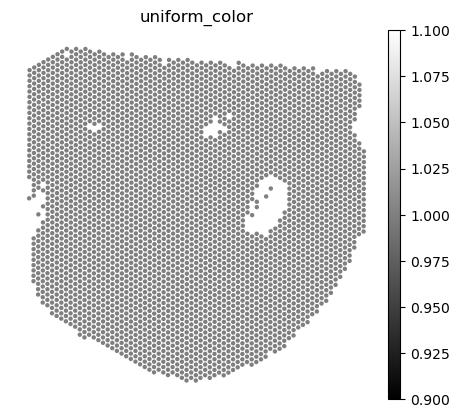

In [11]:
# 调整画图的位点大小
if 'spatial' not in st_data.obsm:
    # 如果不存在，添加 spatial 数据
    spatial_coords = st_data.obs[['x', 'y']].values
    st_data.obsm['spatial'] = spatial_coords
    print("spatial 数据已添加到 obsm 中。")
else:
    print("obsm 中已存在 spatial 数据，跳过添加。")
st_data.obs['uniform_color'] = 1
sc.pl.spatial(
    st_data,
    color='uniform_color',  # 伪彩色列
    color_map='gray',       # 单色显示
    spot_size=150,           # 点大小
    frameon=False,          # 关闭边框
    show=False              # 禁用自动显示
)

## 1.细胞映射

In [12]:
mi.get_cca(sc_data, st_data, path, GPU = True)

文件 ./results/mouse_old_sub_MajorType/cca.npy 已存在，跳过计算


In [13]:
mi.get_scc(sc_data, path, GPU = True)

文件 ./results/mouse_old_sub_MajorType/sccmat_scc.npy 已存在，跳过计算


In [14]:
perc = 0.005
mi.get_mapping(path, perc)

文件 ./results/mouse_old_sub_MajorType/gamma.subset.npy 已存在，跳过计算


In [15]:
# SCC n_samples = 30
n_samples = 20 #采样数量
min_cell = 20 #至少存在的细胞数量
spot_size = 150 #画图的位点大小
mi.build_image(sc_data, st_data, celltype, spot_size, n_samples, min_cell, inhere = 'recluster', path = path)

AnnData object with n_obs × n_vars = 21041 × 3681
    obs: 'MajorType'
    var: 'x', 'y'
obsm 中已存在 spatial 数据，跳过添加。
文件 ./results/mouse_old_sub_MajorType/image 已存在，跳过计算


/data/hgh/projects/20241204_ST/SPICE​-main/mi/mapping.py:994: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad_map = sc.AnnData(X=gamma,obs=obs_df,var=pd.DataFrame(index=st_data.obs_names))


## 2.距离计算

In [16]:
from concurrent.futures import ProcessPoolExecutor, wait, FIRST_EXCEPTION

# def run_parallel():
#     # 注意：多进程环境下，所有参数必须可序列化（pickle）
#     with ProcessPoolExecutor(max_workers=2) as executor:
#         # 提交任务
#         future1 = executor.submit(mi.image_similarity, path)
#         future2 = executor.submit(mi.moran_similarity,
#                                   celltype = sc_data.obs[celltype].values,
#                                   sc_index = sc_data.obs_names.values,
#                                   spatial_coords = st_data.obs[['x', 'y']].to_numpy(),
#                                   st_index = st_data.obs_names.values,
#                                   path = path,
#                                   k=8) #k代表knn的邻接节点数量
        
#         # 等待任务完成（或第一个错误）
#         done, _ = wait([future1, future2], return_when=FIRST_EXCEPTION)
        
#         # 检查任务状态
#         for future in done:
#             if future.exception():
#                 print(f"任务出错: {future.exception()}")
#                 # 取消未完成的任务
#                 future1.cancel() if not future1.done() else None
#                 future2.cancel() if not future2.done() else None
#                 raise future.exception()  # 抛出异常
        
#         print("两个任务均完成")

# run_parallel()

mi.batch_image_similarity(path, batch_size = 32)

文件 ./results/mouse_old_sub_MajorType/distance/moran/moran_similarity.npy 已存在，跳过计算
文件已存在，跳过计算


In [17]:
mi.distance_score(path)

文件 ./results/mouse_old_sub_MajorType/st_score.csv 已存在，跳过计算


## 3.结合配受体对信息得到最终细胞通讯

In [18]:
weight = 0.7 #空间权重
df = pd.read_csv(f'./results/{data_name}_MajorType/CCI_cell2cell.csv', index_col=0)

In [19]:
mi.cal_CCI(df, weight, path)

被删除的行（细胞类型）: []
被删除的列（细胞类型）: []
df已经归一化，跳过
已保存：./results/mouse_old_sub_MajorType/CCI.csv


In [20]:
#dis: 所有细胞类型对中的细胞对距离
#CCC： 原始CCC
img_dis = np.load(path + 'distance/image/image_similarity.npy', allow_pickle=True)
dis_ct = pd.read_csv(path + 'st_score.csv')
CCC = pd.read_csv(f'./results/{data_name}_MajorType/lr_cell2cell.csv')
CCC_pval = pd.read_csv(f'./results/{data_name}_MajorType/lr_value_cell2cell.csv')
#choose选择img或者moran，显著性阈值threshold

In [21]:
mi.cal_CCC(sc_data = sc_data,
           CCC = CCC,
           CCC_pval = CCC_pval,
           dis = img_dis,
           dis_ct = dis_ct,
           threshold = 0.05,
           path = path)

{'ABC', 'VSMC'}
匹配的配受体对数量 26
{'VSMC'}
{'GLU', 'VSMC'}
匹配的配受体对数量 12
{'ABC'}
{'EC', 'VSMC'}
匹配的配受体对数量 17
{'EC', 'VSMC'}
匹配的配受体对数量 21
{'EC', 'ABC'}
匹配的配受体对数量 24
{'EpC', 'ABC'}
匹配的配受体对数量 19


/data/hgh/anaconda3/envs/py37-torch22/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


{'EpC', 'VSMC'}
匹配的配受体对数量 22
{'OEG', 'GLU'}
匹配的配受体对数量 19
{'GLU'}
{'CPEpiC', 'VSMC'}
匹配的配受体对数量 17
{'ABC', 'VSMC'}
匹配的配受体对数量 23
{'VSMC', 'Astrocyte'}
匹配的配受体对数量 20
{'ABC', 'GLU'}
匹配的配受体对数量 16
{'EpC', 'ABC'}
匹配的配受体对数量 26
{'EC', 'Astrocyte'}
匹配的配受体对数量 21
{'EC', 'EpC'}
匹配的配受体对数量 21
{'EC'}
{'OEG', 'ABC'}
匹配的配受体对数量 18
{'Macrophage'}
{'EC', 'GLU'}
匹配的配受体对数量 10
{'GABA', 'VSMC'}
匹配的配受体对数量 16
{'OEG', 'VSMC'}
匹配的配受体对数量 20
{'ABC', 'Astrocyte'}
匹配的配受体对数量 20
{'Microglia', 'Macrophage'}
匹配的配受体对数量 26
{'Pericyte', 'VSMC'}
匹配的配受体对数量 13
{'EpC'}
{'VSMC', 'GLU'}
匹配的配受体对数量 20
{'OEG', 'VSMC'}
匹配的配受体对数量 16
{'EC', 'Pericyte'}
匹配的配受体对数量 16
{'EC', 'ABC'}
匹配的配受体对数量 15
{'ABC', 'GLU'}
匹配的配受体对数量 19
{'Microglia'}
{'EC', 'OEG'}
匹配的配受体对数量 18
{'GABA', 'GLU'}
匹配的配受体对数量 17
{'EC', 'OEG'}
匹配的配受体对数量 19
{'EpC', 'GLU'}
匹配的配受体对数量 6
{'CPEpiC', 'ABC'}
匹配的配受体对数量 16
{'Microglia', 'Macrophage'}
匹配的配受体对数量 23
{'EpC', 'VSMC'}
匹配的配受体对数量 11
{'GABA', 'OEG'}
匹配的配受体对数量 16
{'EpC', 'Astrocyte'}
匹配的配受体对数量 14
{'OEG', 'Astrocyte'}
匹配的配受体对数量 19
{'G

/data/hgh/anaconda3/envs/py37-torch22/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
